# Week 12 Exercises


## Ex1: Dimensionality Reduction with Autoencoder

Write an autoencoder in pytorch and use it to compute a dimensionality reduction for the MNIST digits (as used in PCA exercise) to $k$ numbers (hidden layer size).
Then compare to PCA by plotting the reconstructed data points

Technically you must complete the autoencoder class below.

- Implement cost, encode and decode in the AutoEncoder class.  
   For n data points with dimension d the cost is
  $$
  \frac{1}{dn} \sum_{i=1}^n \sum_{j=1}^d (x_{i, j} - \hat{x}_{i, j})^2
  $$
  where $\hat{x} = \textrm{dec}(\textrm{enc}(x))$ the result of encoding and then decoding $x$. Note that we normalize by $1/dn$ and not just $1/n$ like in the lecture. This is purely a practical choice that makes it easier to deal with learning rates.
  Let $k$ denote the hidden layer size then:
  - The encoder is given as $\textrm{enc}(x) = \textrm{relu}(x W_1 + b_1)$, where $W_1$ is a matrix of size (784, k) and $b_1$ is of size (1, k)
  - Similarly the decoder is $\textrm{dec}(x) = (x W_2 + b_2)$ where $W_2$ is a matrix of size (k, 784) and $b_2$ is of size (1, 784)
- Test the code by running simple_test and set hidden size to 16 and epochs to at least 10. It may take some time to actually fit.

In the first cell we load the MNIST OCR data in pytorch way and show how to use the data iterators.
The autoencoder class is in the next


Input Images


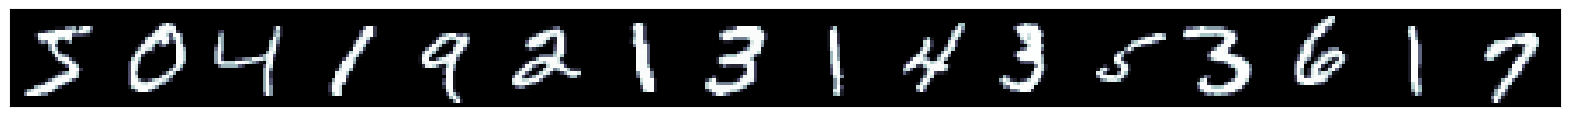

Input Images


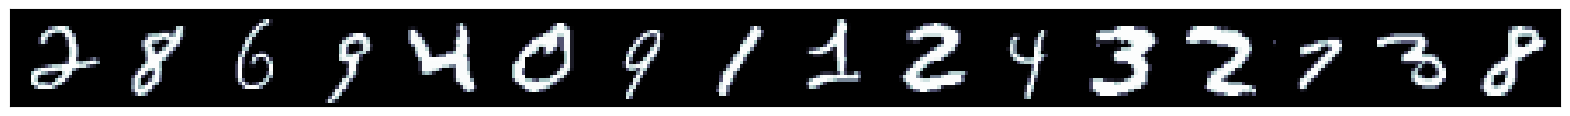

Input Images


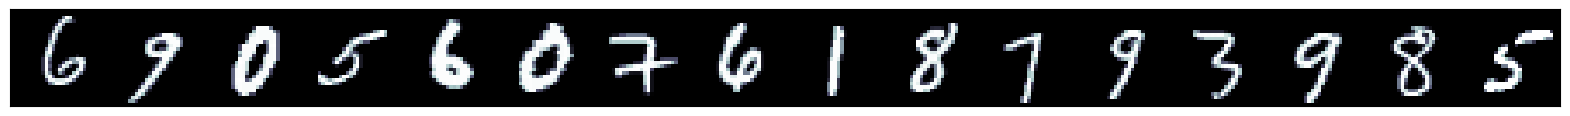

Input Images


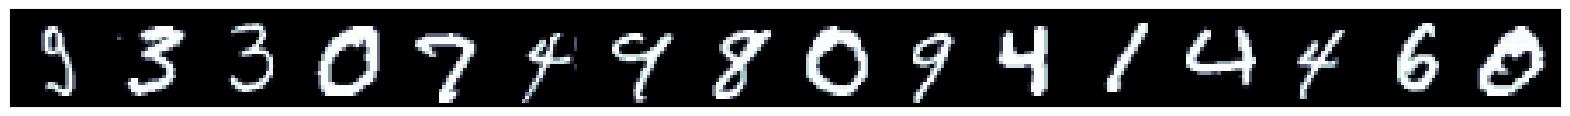

Input Images


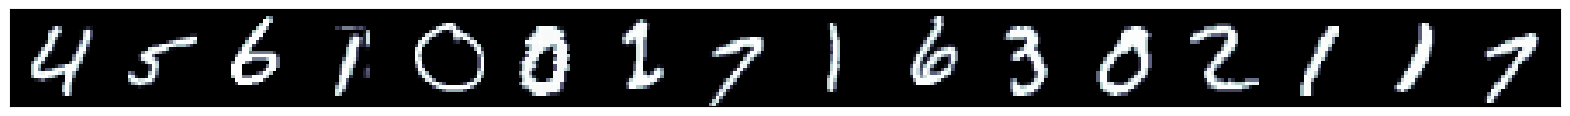

Input Images


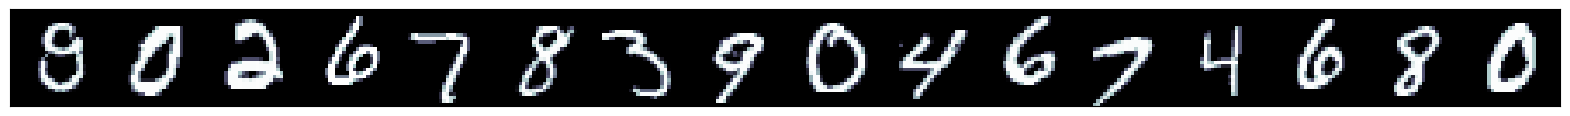

Input Images


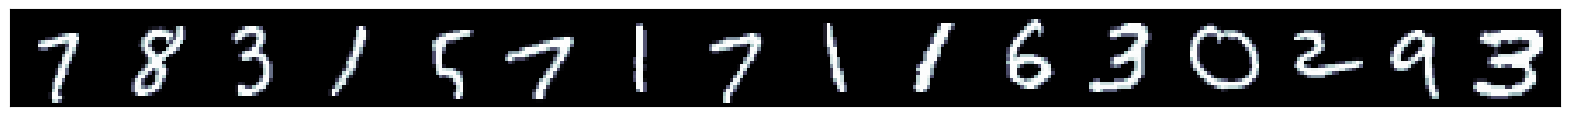

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import optim
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np


def plot_images(dat, k=16):
    """Plot the first k vectors as 28 x 28 images"""
    size = 28
    x2 = dat[0:k, :].reshape(-1, size, size)
    x2 = x2.transpose(1, 0, 2)
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.imshow(x2.reshape(size, -1), cmap="bone")
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,))
    ]
)

batch_size = 16
dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=False
)
# works like this
for idx, (X, y) in enumerate(train_loader):
    x_vec = X.reshape(-1, 784)
    print("Input Images")
    plot_images(
        x_vec.numpy(), k=x_vec.shape[0]
    )  # move to numpy only relevant when needing data in that format
    if idx > 5:
        break


Epoch: 1, Mean Least Square loss: 0.08182830459872882
Epoch: 2, Mean Least Square loss: 0.06241885132690271
Epoch: 3, Mean Least Square loss: 0.060006134248773255
Epoch: 4, Mean Least Square loss: 0.05640217292904854
Epoch: 5, Mean Least Square loss: 0.05181438208222389
Epoch: 6, Mean Least Square loss: 0.04729471375346184
Epoch: 7, Mean Least Square loss: 0.043626165188352266
Epoch: 8, Mean Least Square loss: 0.040810503740111984
Epoch: 9, Mean Least Square loss: 0.03853703615268071
Epoch: 10, Mean Least Square loss: 0.03659873140851656
torch.Size([16, 1, 28, 28])
Input Images


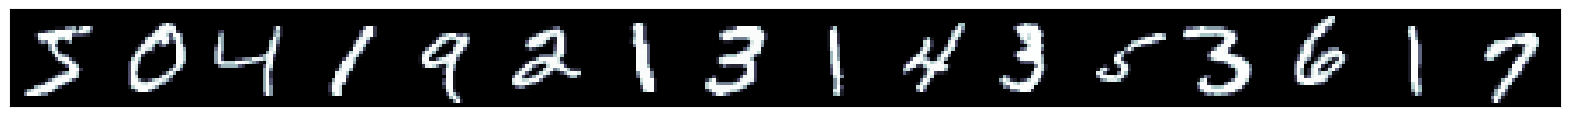

Reconstructed Images


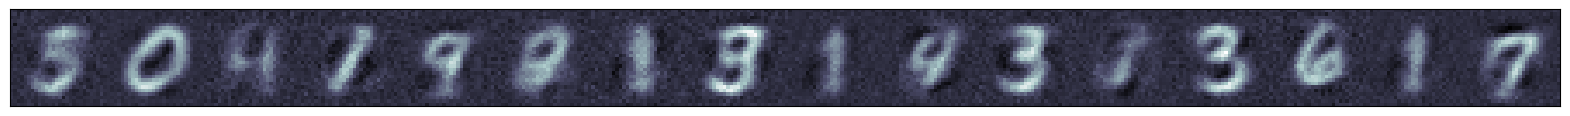

AutoEncoder of dimension 32
Test Accuracy using AutoEncoder: 75.3


In [ ]:
from sklearn.linear_model import SGDClassifier


class AutoEncoder:
    def __init__(self):
        """The parameters required to be set by fit method"""
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None

    def cost(self, X, W1, b1, W2, b2):
        """Compute (coordinate-wise) Least Squares Loss of reconstructing the input.
        The clamp function may be useful

          X: torch.tensor shape (n, d) - Data
          W1: torch.tensor shape (d, h) - weights
          b1: torch.tensor shape (1, h) - bias weight
          W2: torch.tensor shape (h, d) - weights
          b2: torch.tensor shape (1, d) - bias weight
        returns pytorch tensor with least squared cost
        """

        loss = None
        ### YOUR CODE HERE
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2

        loss = torch.sum((X - self.decode(self.encode(X))) ** 2) / (
            X.shape[0] * X.shape[1]
        )

        ### END CODE
        return loss

    def fit(self, data_loader, hidden_size=32, epochs=5):
        """GD Learning Algorithm with pytorch

        Args:
        data_loader: torch dataloader allows enumeration over data
        hidden_size: int
        epochs: int

        sets
        """

        def my_init(s_to, s_from):
            """Standard way to initialize matrices in neural nets - you can ignore it"""
            w = torch.zeros(s_to, s_from)
            b = torch.zeros(s_to, 1)
            nn.init.kaiming_uniform_(w, a=np.sqrt(5))
            bound = 1 / np.sqrt(s_from)
            nn.init.uniform_(b, -bound, bound)
            return torch.transpose(w, 1, 0), torch.transpose(b, 1, 0)

        W1, b1 = my_init(hidden_size, 784)
        W2, b2 = my_init(784, hidden_size)
        for i, z in enumerate([W1, b1, W2, b2]):
            z.requires_grad_()

        sgd = optim.SGD(params={W1, b1, W2, b2}, lr=0.1, weight_decay=1e-4)
        # sgd = optim.AdamW(params={W1, b1, W2, b2}, lr=0.0001, weight_decay=1e-4)
        running_loss = 0.0

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_count = 0
            running_loss = 0
            for idx, (X, y) in enumerate(data_loader):
                sgd.zero_grad()
                inputs = X.view(-1, 784)
                loss = self.cost(inputs, W1, b1, W2, b2)
                epoch_loss += loss.item()
                epoch_count += 1
                running_loss += loss.item()
                if idx % 10 == 9:
                    print(
                        "Running loss: {2:.3f}".format(
                            epoch + 1, idx + 1, epoch_loss / epoch_count
                        ),
                        end="\r",
                    )
                    running_loss = 0.0

                loss.backward()
                sgd.step()
            print(
                "Epoch: {0}, Mean Least Square loss: {1}".format(
                    epoch + 1, epoch_loss / epoch_count
                )
            )

        self.W1 = W1.detach()  # .numpy()
        self.W2 = W2.detach()  # .numpy()
        self.b1 = b1.detach()  # .numpy()
        self.b2 = b2.detach()  # .numpy()

    def encode(self, X):
        """Compute the embedded inputs.

        Args:
         X: torch.tensor shape (n, d)

        Returns:
         decoded: torch.tensor shape (n, h) using self.W1, self.b1 and ReLU
        """

        encoded = None
        ### YOUR CODE HERE
        encoded = torch.relu(torch.matmul(X, self.W1) + self.b1)
        ### END CODE
        return encoded

    def decode(self, X):
        """Compute the reconstructed inputs from the encoding.

        Args:
         X: torch.tensor shape (n, h)

        Returns:
         decoded: torch.tensor shape (n, d) using self.W2, self.b2
        """

        decoded = None
        ### YOUR CODE HERE
        decoded = torch.matmul(X, self.W2) + self.b2
        ### END CODE
        return decoded


def simple_test(hidden_size=32, epochs=1):
    net = AutoEncoder()
    net.fit(data_loader=train_loader, hidden_size=hidden_size, epochs=epochs)
    X_sample, y_sample = next(iter(train_loader))
    print(X_sample.shape)
    x_vec = X_sample.view(-1, 784)
    with torch.no_grad():
        reconstructed_sample = net.decode(net.encode(x_vec)).numpy()
    print("Input Images")
    plot_images(x_vec.numpy(), k=x_vec.shape[0])
    print("Reconstructed Images")
    plot_images(reconstructed_sample, k=x_vec.shape[0])

    # data, labels =
    data = dataset1.data.view(-1, 784).type(torch.FloatTensor)
    labels = dataset1.targets
    # reduce size for speed
    rp = np.random.permutation(len(labels))
    train_dat = data[rp[:5000], :]
    test_dat = data[rp[5000:6000], :]
    train_lab = labels[rp[:5000]].numpy()
    test_lab = labels[rp[5000:6000]].numpy()

    enc_train_dat = net.encode(train_dat)
    clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200, fit_intercept=True)
    clf.fit(enc_train_dat, train_lab)
    enc_test_dat = net.encode(test_dat)
    acc = (clf.predict(enc_test_dat) == test_lab).mean()
    print("AutoEncoder of dimension", hidden_size)
    print("Test Accuracy using AutoEncoder:", 100 * acc)


simple_test(32, epochs=10)

## Ex2: Random Projections Experiment

In the following, you must implement the random projection known as the Johnson-Lindenstrauss transform.

The code you must implement:

1. Fill out the random projection matrix Z such that a data matrix X can be embedded as XZ. Z should have the right scaling and normal distributed entries. Z should have k columns (the target dimension for embedding, called k in the lectures).
2. Project the training data using Z
3. Train the SGD classifier on the projected training data.


In [ ]:
import numpy as np
import os
from sklearn.linear_model import SGDClassifier
import torchvision.datasets as datasets

# Load full dataset
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=None
)

# data, labels =
data = mnist_trainset.data.numpy().reshape((60000, 28 * 28))
labels = mnist_trainset.targets.numpy()

# reduce size for speed
rp = np.random.permutation(len(labels))
dat = data[rp[:6000], :]
lab = labels[rp[:6000]]

train_dat = dat[:5000, :]
test_dat = dat[5000:, :]
train_lab = lab[:5000]
test_lab = lab[5000:]

for k in [16, 32, 64, 128]:
    clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200, fit_intercept=True)
    Z = None
    ### YOUR CODE HERE
    Z = np.random.normal(0, 1 / k, (28 * 28, k))  # 784 x k
    proj_train_dat = train_dat @ Z
    clf.fit(proj_train_dat, train_lab)
    ### END CODE

    proj_test_dat = test_dat @ Z
    acc = (clf.predict(proj_test_dat) == test_lab).mean()
    print("Testing with embedding dimension", k)
    print("Test accuracy of JL", 100 * acc)


Testing with embedding dimension 16
Test accuracy of JL 45.6
Testing with embedding dimension 32
Test accuracy of JL 65.0
Testing with embedding dimension 64
Test accuracy of JL 74.0
Testing with embedding dimension 128
Test accuracy of JL 83.89999999999999


## Ex3: Random Projections and k-Means

In k-means clustering, we partition a set of points $X$ into $k$ clusters $C_1,\dots,C_k$ where in each cluster $C_i$ we choose the mean $\mu_i = \frac{1}{|C_i|} \sum_{x \in C_i} x$ as the cluster center.

The cost of a clustering into clusters $C_1,\dots,C_k$ is then $\sum_{i=1}^k \sum_{x \in C_i}\|x-\mu_i\|^2$.

In the following, you may use without proof that the cost of cluster $C_i$ can be rewritten as $\sum_{x \in C_i}\|x-\mu_i\|^2 = \frac{1}{2|C_i|} \sum_{x \in C_i} \sum_{y \in C_i} \|x - y\|^2$.

Argue that if we apply a projection to $X$ to obtain data set $X'$ in $d'$ dimensions, then if all pairwise distances between points in $X$ are preserved to within a multiplicative $(1 \pm \varepsilon)$ in $X'$, then the cost of _any_ clustering (partitioning into $k$ clusters) is preserved to within a factor $(1 \pm \varepsilon)$ (that is, the cost of the cluster using points in $X'$ is within a factor $(1 \pm \varepsilon)$ of the cost when using $X$).

The above implies that we may instead perform k-means clustering on $X'$ and still obtain high quality clusterings.


## Ex4: Random Projections and Inner Products

Recall that the many linear models we have seen in the course base their predictions on inner products $w^\intercal x$. Moreover, recall from the lecture that the Johnson-Lindenstrauss transform guarantees (with high probability), for a set of feature vectors $x_1,\dots,x_n \in R^d$ that:

$$
\|f(x_i) - f(x_j)\|_2^2 \in (1 \pm \varepsilon)\|x_i - x_j\|_2^2
$$

for all $x_i, x_j$. In this exercise, you must show that the Johnson-Lindenstrauss transform also preserves inner products with high probability. For this, we make an assumption that $-x_i$ is among $x_1,\dots,x_n$ for every $x_i$ and that $f$ is linear.

1. Assume $x_i$ and $x_j$ have unit length. Show that $|f(x_i)^\intercal f(x_j) - x_i^\intercal x_j| \leq 2 \varepsilon$ when all distances are preserved to within $(1\pm \varepsilon)$. Hint: The identity $4 \langle a, b\rangle = \|a+b\|_2^2 - \|a-b\|_2^2$ may be useful. Also, for two unit vectors $a,b$ it holds that $\|a+b\|_2^2 \leq 4$ and $\|a-b\|_2^2 \leq 4$.

2. Assume all distances are preserved to within $(1\pm \varepsilon)$ between the set of normalized vectors $x'_i=x_i/\|x_i\|$, i.e. $\|f(x'_i)-f(x'_j)\|_2^2 \in (1 \pm \varepsilon)\|x'_i-x'_j\|_2^2$. Show that this implies $|f(x_i)^\intercal f(x_j) - x_i^\intercal x_j| \leq 2 \varepsilon \|x_i\|\|x_j\|$.


## Ex5: Random Projections and Support Vector Machines

Recall from the support vector machines lectures that in the linearly separable case, we search for a hyperplane $w$ with the largest margin to the data. Assume there is such a hyperplane (let us ignore the bias $b$), specified by the normal vector $w$ of unit length, where the margin (geometric and functional since $\|w\| = 1$) to every training example is at least $\gamma$. Assume furthermore that every training example $x_i$ has norm at most $R$.

Show that a random projection into $k=C((R/\gamma)^2 \ln n)$ dimensions, for a big enough constant $C>0$, guarantees that the data is still linearly separable with high probability. Hint: It may be useful to use the properties proved in exercise 4 above and to use $\varepsilon = \gamma/(2R)$.

We remark that since the VC-dimension of hyperplanes is $d+1$, the reduction to $k$ dimensions shows that a much smaller VC-dimension might suffice if there exists a separating hyperplane $w$ with large margins in $R^d$.
